In [1]:
using StaticArrays
using LinearAlgebra
# using Makie
using LsqFit
include("src\\Elastic.jl")
using .Elastic
using DelimitedFiles
using Distributions
using Statistics
using Plots
using Test
using IterTools
using BenchmarkTools
using LaTeXStrings
using JSON

In [55]:
atom_positions = [
    Vector([0.0, 0.0, 0.0]),
    Vector([0.0, 0.5, 0.5]),
    Vector([0.5, 0.0, 0.5]),
    Vector([0.5, 0.5, 0.0]),
    Vector([1.0, 0.0, 0.0]),
    Vector([0.0, 1.0, 0.0]),
    Vector([0.0, 0.0, 1.0]),
    Vector([0.5, 1.0, 0.5]),
    Vector([1.0, 0.5, 0.5]),
    Vector([0.5, 0.5, 1.0]),
    Vector([1.0, 0.0, 1.0]),
    Vector([1.0, 1.0, 0.0]),
    Vector([0.0, 1.0, 1.0]),
    Vector([1.0, 1.0, 1.0])
] 
kb=8.617332385e-5 #eV/K
amuM=1.03642701e-4 #[m]/amu
Mcu=26.9815385 #amu
lattice_constant = 4.032 #A

# 定义铜的FCC晶胞的基矢量
lattice_vectors = collect((Matrix([
    lattice_constant 0.0 0.0; #a1
    0.0 lattice_constant 0.0; #a2
    0.0 0.0 lattice_constant] #a3
))')

# 创建铜的原子列表
atoms = [Atom(pos,Mcu*amuM) for pos in atom_positions]


cell=UnitCell(lattice_vectors,atoms)
cpcell=copycell(cell,2,2,2)
fcell=filtercell(cpcell)
visualize_unitcell_atoms(fcell)
ct=6.5
embeddingAl2=Embedding(embedding_energyAl2, embedding_forceAl2i)
interaction=Interaction(EMAAl2_phi, EMAAl2_phi_gradient, ct, 0.1, embeddingAl2)
# interaction=Interaction(EMAAl2_phi, EMAAl2_phi_gradient, ct, 0.1)
xx=3.5:0.001:6.5
y=interaction.cutenergy.(xx)
Plots.plot(xx,y,label="",xlabel=L"r_{ij}/\mathrm{\AA}",ylabel=L"\phi/\mathrm{eV}",title=L"\phi-r_{ij}", xlabelfontsize=14, ylabelfontsize=14, titlefontsize=16,lw=2)
cl,El=minimizeEnergy!(fcell, interaction,rg=[3.8,4.5],n=100)

(3.8:0.007070707070707071:4.5, [-832.0950777254744, -835.6119546669437, -839.0453005220302, -842.3852798062818, -845.6226168976514, -848.7487896493258, -851.7561801416122, -854.638188018945, -857.3893112992619, -860.0051991690432  …  -832.435458103577, -831.1293358500549, -829.7754053268482, -828.3745267070002, -826.9280651343017, -825.4378349332637, -823.9060402999087, -822.3352130046753, -820.7281475826196, -819.0878344293711])

In [65]:
dmat=deform_mat(5,0.1)
deform_cell!(fcell,dmat,interaction)

In [66]:
ft=Force_Tensor(fcell,interaction)

3×3 SMatrix{3, 3, Float64, 9} with indices SOneTo(3)×SOneTo(3):
  0.00642928  6.69758e-9   -0.0272776
  2.89335e-8  0.000918638  -5.35806e-9
 -0.0272775   1.07161e-8    0.0101028

In [67]:
matrix_to_latex(Matrix(ft),n=5)

L"$\left[\begin{matrix}0.00643 & 0.00000 & -0.02728 \\ 0.00000 & 0.00092 & -0.00000 \\ -0.02728 & 0.00000 & 0.01010\end{matrix}\right]$"

In [ ]:
# for atom in fcell.atoms
#     atom.position+=randn(3)*0.01
# end

In [56]:
# re=gradientDescent!(fcell,interaction,ap=0.1,tol=-1e-8,checktime=1,maxiter=100)

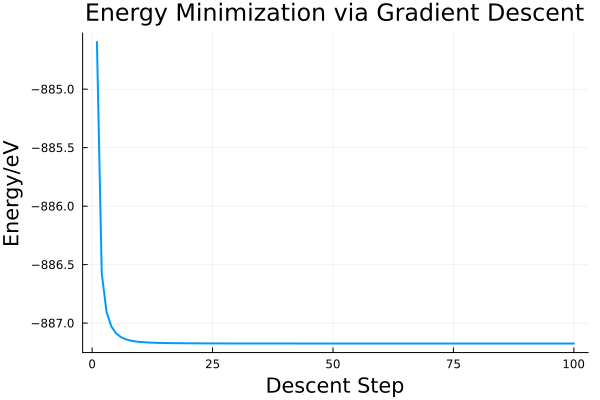

In [54]:
plot(re,xlabel="Descent Step",ylabel="Energy/eV",label="",title="Energy Minimization via Gradient Descent",xlabelfontsize=14, ylabelfontsize=14, titlefontsize=16,lw=2)

In [18]:
apply_PBC!(fcell)

In [19]:
visualize_unitcell_atoms(fcell)

In [2]:
P00=160.2176565 #Gpa/[p]
projectname="Deformer_output\\deform_dimaond_111"
Logpath=projectname*"\\Log.json"
configpath=projectname*"\\Config.txt"

results = read_json(Logpath);
# flaglist=eval(Meta.parse(read_config(configpath, "flaglist=")))
flaglist=[0,1,2,3,4,5,6]
deltalist=[-0.01,0.01]
tol=0.01

Fmtotal=Vector{Array{Matrix}}(undef,0)
Fstdtotal=Vector{Array{Matrix}}(undef,0)
for delta in deltalist
    Flm=Array{Matrix}([])
    Flstd=Array{Matrix}([])
    for flag in flaglist
        dl2=Vector{Float64}([])
        Fl2=Matrix{Float64}(undef, 6, 0)
        for re in results
            if re["flag"]==flag && re["delta"]==delta
                # push!(Ul2,Float64(re["dUdhij"]))
                Ft=re["forcetensor"]
                Fl2=hcat(Fl2,-(FT2sigma(Ft)))
                push!(dl2,Float64(re["delta"]))
            end
        end
        mFl2=mean(Fl2,dims=2)
        push!(Flm,mFl2)
        push!(Flstd,std(Fl2,dims=2))
    end
    push!(Fmtotal,Flm)
    push!(Fstdtotal,Flstd)
end

In [3]:
Fmtotal

2-element Vector{Array{Matrix}}:
 [[NaN; NaN; … ; NaN; NaN;;], [NaN; NaN; … ; NaN; NaN;;], [NaN; NaN; … ; NaN; NaN;;], [NaN; NaN; … ; NaN; NaN;;], [NaN; NaN; … ; NaN; NaN;;], [NaN; NaN; … ; NaN; NaN;;], [NaN; NaN; … ; NaN; NaN;;]]
 [[NaN; NaN; … ; NaN; NaN;;], [NaN; NaN; … ; NaN; NaN;;], [NaN; NaN; … ; NaN; NaN;;], [NaN; NaN; … ; NaN; NaN;;], [NaN; NaN; … ; NaN; NaN;;], [NaN; NaN; … ; NaN; NaN;;], [NaN; NaN; … ; NaN; NaN;;]]

In [4]:
Cml=Vector{Matrix{Float64}}(undef,0)
Cstdl=Vector{Matrix{Float64}}(undef,0)
for i in 1:length(deltalist)
    ep1=Matrix{Float64}(undef, 6, 0)
    s1std=Matrix{Float64}(undef, 6, 0)
    s1m=Matrix{Float64}(undef, 6, 0)
    Flm=Fmtotal[i]
    Flstd=Fstdtotal[i]
    for flag in flaglist
        if flag>0
            ep1=hcat(ep1,DF2elastic(flag,deltalist[i]))
            s1std=hcat(s1std,Flstd[flag+1]-Flm[1])
            s1m=hcat(s1m,Flm[flag+1])
        end
    end
    C1std=s1std*inv(ep1).*P00
    C1m=s1m*inv(ep1).*P00
    push!(Cml,C1m)
    push!(Cstdl,C1std)
end

In [6]:
mean(Cml)

6×6 Matrix{Float64}:
 105.155       60.0291      61.046      0.109617     0.56039    1.42926
  61.1377     104.22        61.8488    -2.18636      1.12642   -0.822788
  61.9624      59.7108     104.704     -0.0957196   -1.97119   -0.786175
   0.503891     0.0911488    0.910279  37.3233       0.408363  -0.413715
   0.941943     0.314485    -0.551219  -0.00968481  36.3034     0.278465
  -0.0934193    0.894313     0.375648   0.0695777   -0.792386  36.7607

In [7]:
Cstdl[2]./sqrt(50000)

6×6 Matrix{Float64}:
 0.0410972  0.0427914  0.0436244  0.0410361  0.0402235  0.0388163
 0.0386513  0.0400729  0.0390224  0.0397816  0.0376655  0.036246
 0.0449979  0.0462943  0.0504411  0.0461467  0.0472925  0.0438659
 0.0184474  0.0177709  0.0159888  0.0174161  0.0189506  0.0179644
 0.0205694  0.021522   0.0201249  0.0224767  0.0234308  0.020393
 0.0224736  0.017349   0.0222713  0.0175141  0.0183667  0.0157766

In [10]:
Cml[2]

6×6 Matrix{Float64}:
 98.2711    58.4183    58.8937    -0.922485   0.40594     2.14374
 58.9867    95.5926    60.3817    -4.70111   -0.0613542  -3.70138
 61.2814    56.3542    98.7617    -4.07321   -5.11597    -4.34705
  0.859514  -0.728166   0.552231  37.4144     1.08439    -0.171185
  1.74836   -0.159247  -1.15843   -0.253558  35.8832     -0.121109
  0.348909   1.84041    0.049201  -0.547733   0.522949   37.9808

In [12]:
re=Dict("Cm"=>Cml,"Cstd"=>Cstdl,"Cmm"=>mean(Cml))
open("$projectname\\results.json","w") do io
    write(io,JSON.json(re))
end

3501

In [13]:
Clo=Vector{Float64}([])
Cln=Vector{Float64}([])
Cla=Vector{Float64}([])
x=Vector{Float64}([])
for i in 1:Int(length(dltotal[1])/2)
    ep1=Matrix{Float64}(undef, 6, 0)
    ep2=Matrix{Float64}(undef, 6, 0)
    s1=Matrix{Float64}(undef, 6, 0)
    s2=Matrix{Float64}(undef, 6, 0)

    for flag in flaglist
        dl2=dltotal[flag]
        Fl2=Fltotal[flag]

        ep1=hcat(ep1,DF2elastic(flag,dl2[end-i]))
        ep2=hcat(ep2,DF2elastic(flag,dl2[i]))
        s1=hcat(s1,Fl2[:,end-i])
        s2=hcat(s2,Fl2[:,i])
    end
    push!(x,abs(dltotal[1][i]))
    Cl1=s1*inv(ep1).*P00
    Cl2=s2*inv(ep2).*P00
    Cl3=(Cl1+Cl2)/2
    push!(Clo,Cl1[1,1])
    push!(Cln,Cl2[1,1])
    push!(Cla,Cl3[1,1])
end


UndefVarError: UndefVarError: `dltotal` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

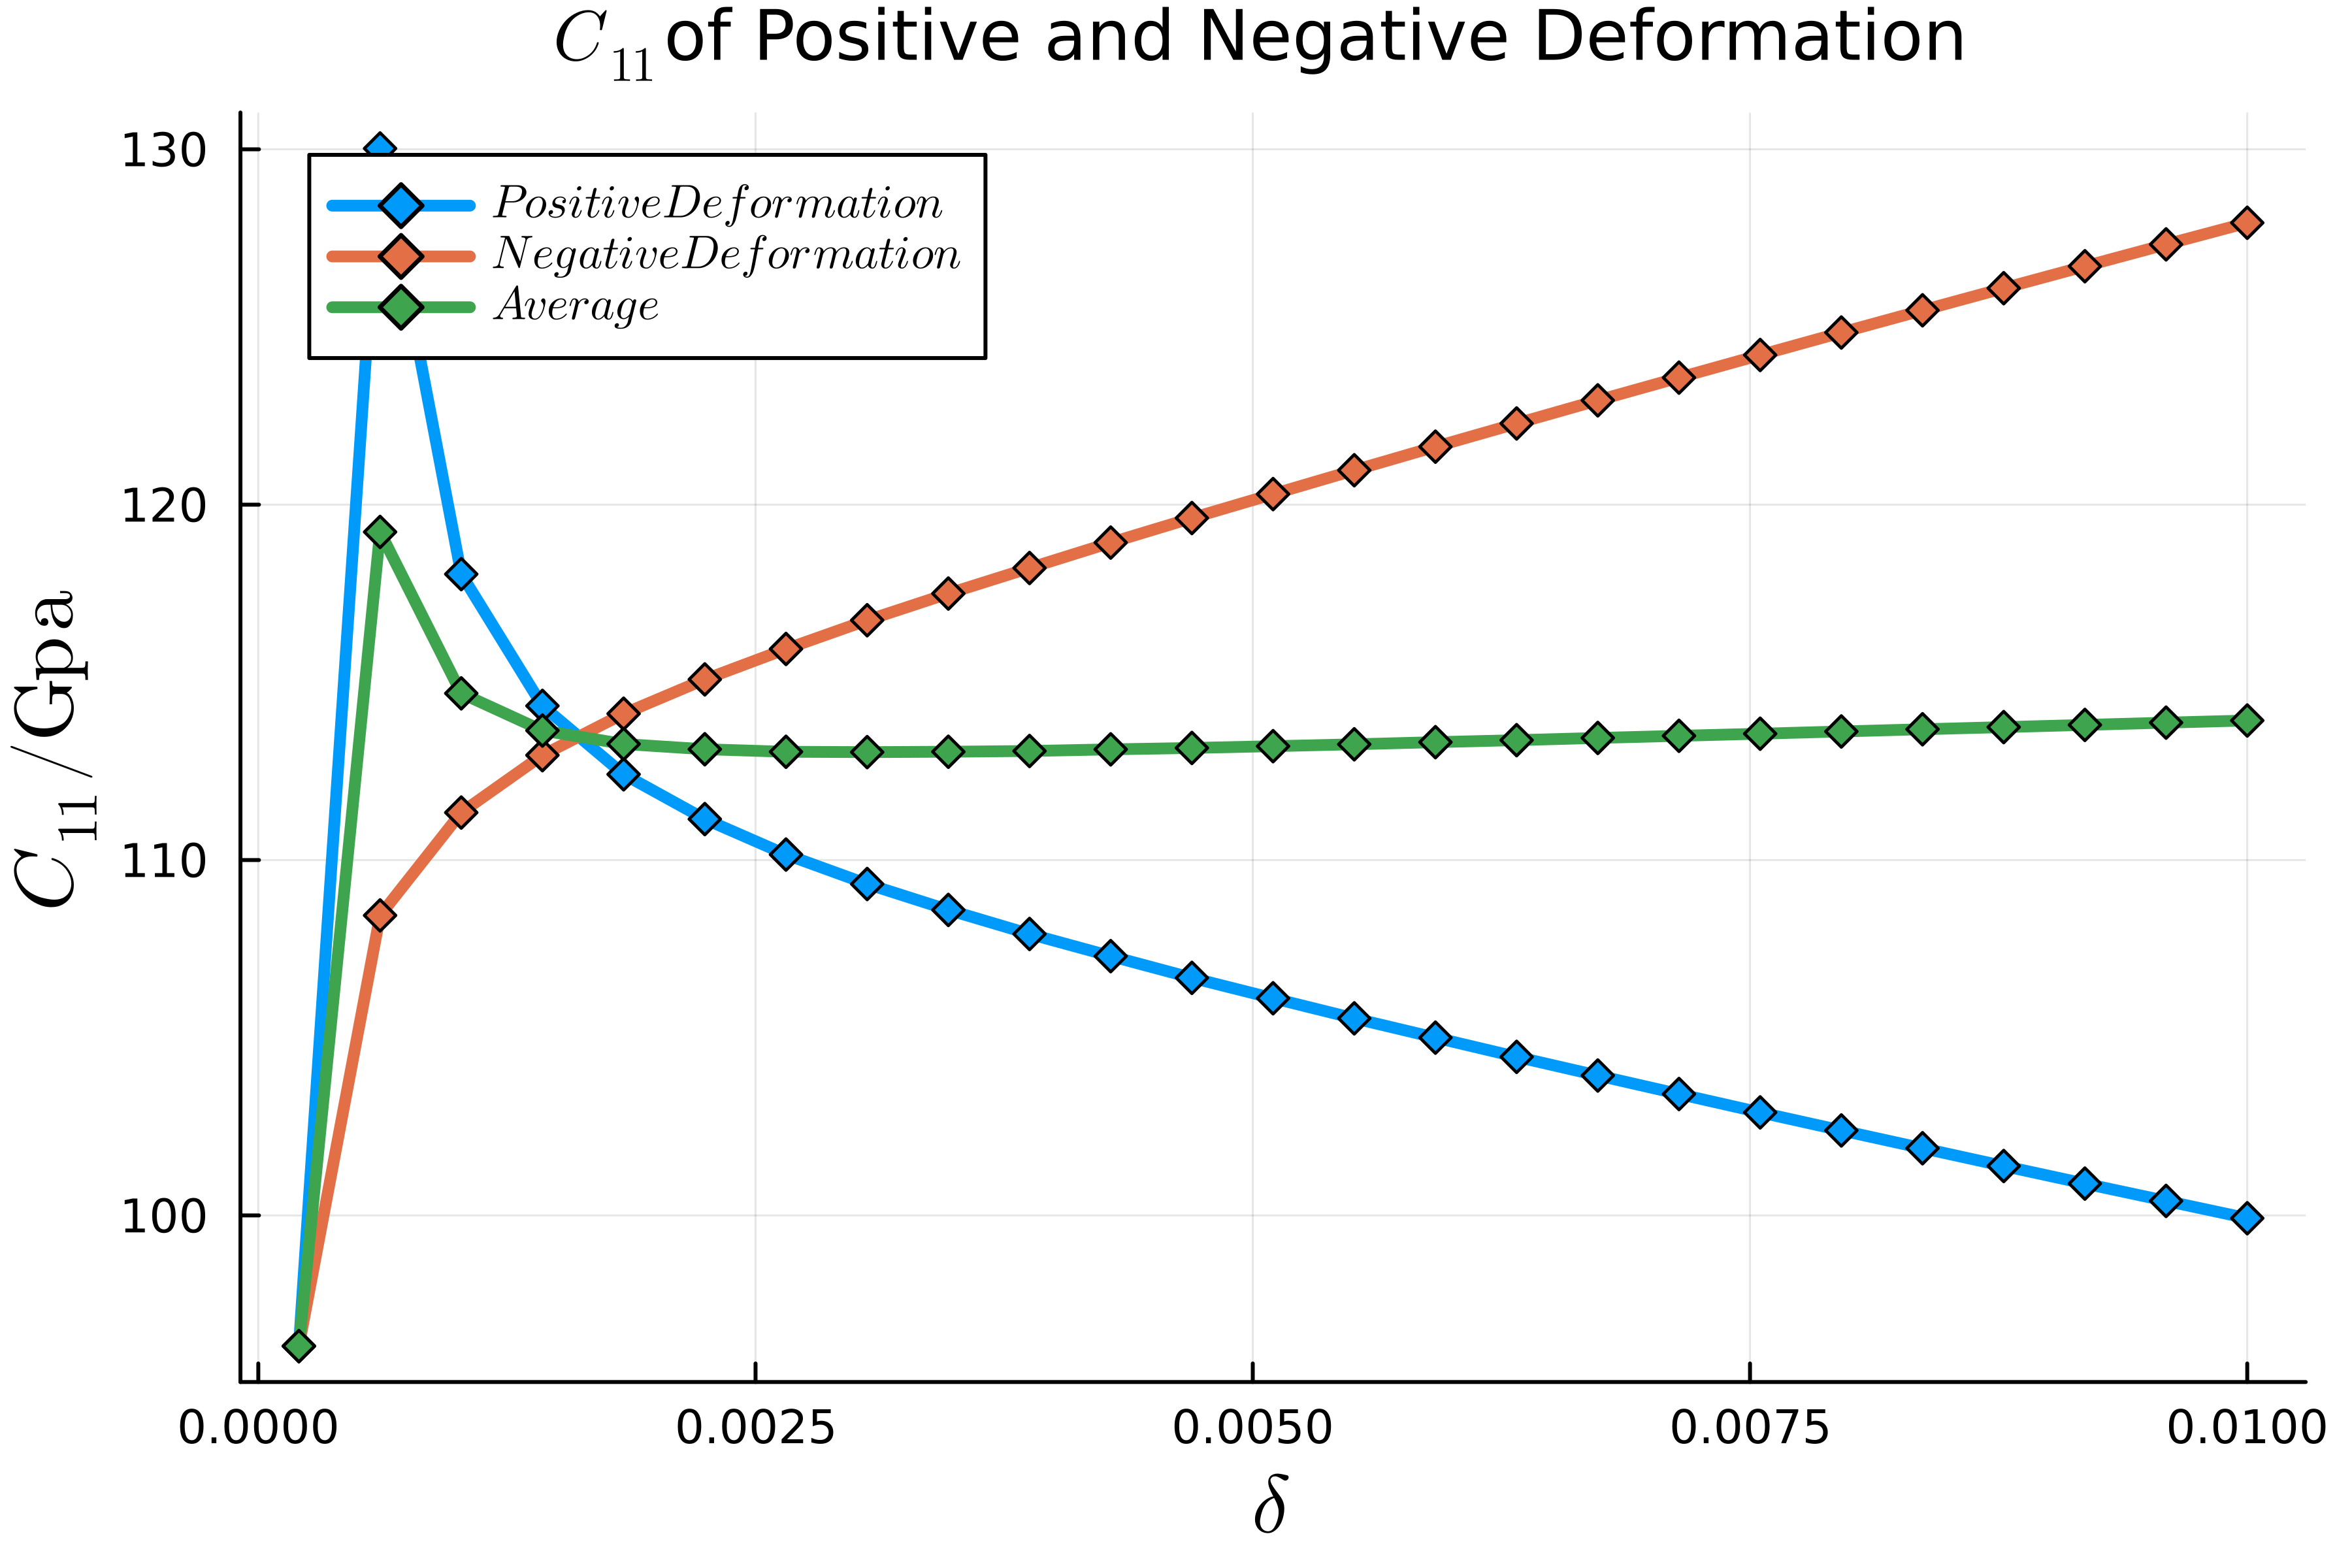

In [11]:
p=plot(x,Clo,lw=3,alpha=1,marker=(:diamond, 4),seriestype=:path,dpi=600,label=L"Positive Deformation",xlabel=L"\delta",ylabel=L"C_{11}/\mathrm{Gpa}",title=L"C_{11}"*"of Positive and Negative Deformation ",xlabelfontsize=14, ylabelfontsize=14, titlefontsize=12)
plot!(x,Cln,lw=3,alpha=1,marker=(:diamond, 4), seriestype=:path,label=L"Negative Deformation")
plot!(x,Cla,lw=3,alpha=1,marker=(:diamond, 4), seriestype=:path,label=L"Average")
savefig("$projectname\\LogFig\\diff.png")
p